In [1]:
import os
from typing import Tuple, List
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tabulate import tabulate

from evolution.base.base_genome import BaseGenome
from evolution.base.base_strategies import Population
from evolution.base.base_geometry import BaseGeometry
from evolution.camera.camera_algorithm import GeneticCameraAlgorithm
from evolution.camera.camera_genome_factory import CameraGenomeFactory
from evolution.camera.camera_genome_parameters import CameraGenomeParameters
from evolution.camera.camera_rendering import render_geometry_with_camera
from evolution.camera.camera_translator import CameraTranslator
from evolution.camera.object_geometry import ObjGeometry
from evolution.strategies.crossover import SinglePoint, TwoPoint
from evolution.strategies.fitness import DistanceMapWithPunishment, DistanceMap
from evolution.strategies.mutation import BoundedUniformMutation, BoundedDistributionBasedMutation
from evolution.strategies.populate import ValueUniformPopulation
from evolution.strategies.selection import Tournament, RouletteWheel
from evolution.strategies.strategy_bundle import StrategyBundle
from evolution.strategies.termination import NoImprovement

from utils.figure_utils import save_figure

In [2]:
CREATE_DATA = False
OUTPUT_FILE = "experiment_history_dev.npz"
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

def check_for_skip():
    if not CREATE_DATA:
        print("SKIPPING CELL")
        raise StopExecution()


In [3]:
DATA_FOLDER = "../data"
OUTPUT_FOLDER = "../output"
plt.style.use(['science','ieee'])

In [4]:
def synthetic_target_edge_image(shape: Tuple[int, int], target_geometry: BaseGeometry,
                                target_genome: BaseGenome) -> np.array:
    edge_image = np.zeros(shape, dtype=np.uint8)
    A, t, r, d = CameraTranslator().translate_genome(target_genome)
    render_geometry_with_camera(edge_image, target_geometry, A, t, r, d, (255,))
    return edge_image


def synthetic_target_dna(shape: Tuple[int, int]):
    fu = max(shape) - 100
    fv = fu
    h, w = shape
    cx, cy = w // 2, h // 2
    tx, ty, tz = 0.00, 2.35, 8.40
    rx, ry, rz = 0.29, 0.00, 0.00
    d0, d1, d2, d3, d4 = np.zeros(5)
    camera_dna = np.array([fu, fv, cx, cy, tx, ty, tz, rx, ry, rz, d0, d1, d2, d3, d4])
    return camera_dna

In [5]:
@dataclass
class HistoryEntry:
    population: Population
    population_fitness: List[float]

In [6]:

class MyGeneticCameraAlgorithm(GeneticCameraAlgorithm):
    def on_display_population(self, current_generation, population: Population, population_fitness: List[float]):
        super().on_display_population(current_generation, population, population_fitness)
        global history, tmp_best
        history.append(HistoryEntry(population, population_fitness))
#        best_value = np.max(population_fitness)
#        lo_value = np.percentile(population_fitness, 20) #np.min(population_fitness)
#        mid_value = np.percentile(population_fitness, 50) # np.mean(population_fitness)
#        hi_value = np.percentile(population_fitness, 80) # np.max(population_fitness)
#        history.append(HistoryEntry(lo_value, mid_value, hi_value, best_value))

In [7]:
np.random.seed(4711)

# 1. Specify all parameters
image_shape = (image_height, image_width) = 600, 800
parameters_file = f"{DATA_FOLDER}/squash/squash_parameters.json"
geometry_file = f"{DATA_FOLDER}/squash/geometries/full_squash_court.obj"

In [8]:
# 2. Construct the needed classes and objects for the algorithm
image = np.zeros((image_height, image_width, 3), dtype=np.uint8)
genome_parameters = CameraGenomeParameters(parameters_file, image_shape)
camera_genome_factory = CameraGenomeFactory(genome_parameters)
camera_translator = CameraTranslator()

fitting_geometry = ObjGeometry(geometry_file)

In [9]:
# ######## Create a synthetic, perfect squash court (edge) image ########
# This step is only needed for synthetic experiments. In a real world application
# one would extract the edges as binary image of the geometric object instead of
# rendering the scene! (see real_squash_example)
real_geometry = fitting_geometry  # Ideally, the target geometry is the fitting geometry
real_dna = synthetic_target_dna(image_shape)
real_genome = camera_genome_factory.create(real_dna, "target_camera")

In [10]:
extracted_edge_image = synthetic_target_edge_image(image_shape, real_geometry, real_genome)
# "extracted_edge_image" is the binary image which will be used for the algorithm
# ########################################################################

# 3. Define your actual strategy
target_dna = synthetic_target_dna(image_shape)
start_dna = synthetic_target_dna(image_shape)
dna_offset = [100, 100, 32, 32, 0.3, 1.0, 3.0, np.deg2rad(+20), np.deg2rad(0), np.deg2rad(10), +0, +0, +0, +0, 0]

start_dna += dna_offset
start_genome = camera_genome_factory.create(start_dna, "opt_camera")

In [11]:
population_strategy = ValueUniformPopulation(16)
fitness_strategy = DistanceMapWithPunishment(DistanceMap.DistanceType.L2, .3)
selection_strategy = RouletteWheel()
crossover_strategy = SinglePoint()
mutation_strategy = BoundedDistributionBasedMutation(genome_parameters)
mutation_strategy.genome_bounds = None
termination_strategy = NoImprovement(300)

strategy_bundle = StrategyBundle(population_strategy,
                                    fitness_strategy,
                                    selection_strategy,
                                    crossover_strategy,
                                    mutation_strategy,
                                    termination_strategy)

In [12]:
history : List[HistoryEntry] = []

# 4. Construct and run the optimization algorithm
camera_algorithm = MyGeneticCameraAlgorithm(genome_parameters, strategy_bundle, extracted_edge_image, fitting_geometry, headless=False)

In [13]:
check_for_skip()

best_possible_fitness = camera_algorithm.fitness(real_genome)
result = camera_algorithm.run(start_dna)
best_genome, best_fitness = result.best_genome

SKIPPING CELL


StopExecution: 

In [14]:
check_for_skip()

#[[ [a0, b0, c0] , [a0, b0, c0], [a0, b0, c0], [a0, b0, c0] ],
# [ [a0, b0, c0] , [a0, b0, c0], [a0, b0, c0], [a0, b0, c0] ],
# [ [a0, b0, c0] , [a0, b0, c0], [a0, b0, c0], [a0, b0, c0] ],
# [ [a0, b0, c0] , [a0, b0, c0], [a0, b0, c0], [a0, b0, c0] ],
# [ [a0, b0, c0] , [a0, b0, c0], [a0, b0, c0], [a0, b0, c0] ],
# [ [a0, b0, c0] , [a0, b0, c0], [a0, b0, c0], [a0, b0, c0] ],
# [ [a0, b0, c0] , [a0, b0, c0], [a0, b0, c0], [a0, b0, c0] ],
# ...
#]
# populations [<GENERATION>, <INDIVIDUAL>, <CAMERA_PARAMETER>]
# populations_fitness[<GENREATION>, <INDIVIDUAL>]
populations = np.array([[p.dna for p in history_entry.population] for history_entry in history])
populations_fitness = np.array([ history_entry.population_fitness for history_entry in history])

np.savez(OUTPUT_FILE, populations=populations, populations_fitness=populations_fitness, start_dna=start_dna, target_dna=target_dna)

SKIPPING CELL


StopExecution: 

In [15]:
npzfile = np.load("experiment_history.npz")
populations = npzfile["populations"]
populations_fitness = npzfile["populations_fitness"]
start_dna = npzfile["start_dna"]
target_dna = npzfile["target_dna"]


In [16]:
real_genome = camera_genome_factory.create(real_dna, "target_camera")
best_possible_fitness = camera_algorithm.fitness(real_genome)

In [17]:
best_values = best_possible_fitness - populations_fitness[:, 0]
lo_values = best_possible_fitness - np.percentile(populations_fitness, 25, axis=1)
mid_values = best_possible_fitness - np.percentile(populations_fitness, 50, axis=1)
hi_values = best_possible_fitness - np.percentile(populations_fitness, 75, axis=1)

best_individuals = populations[:, 0, :]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


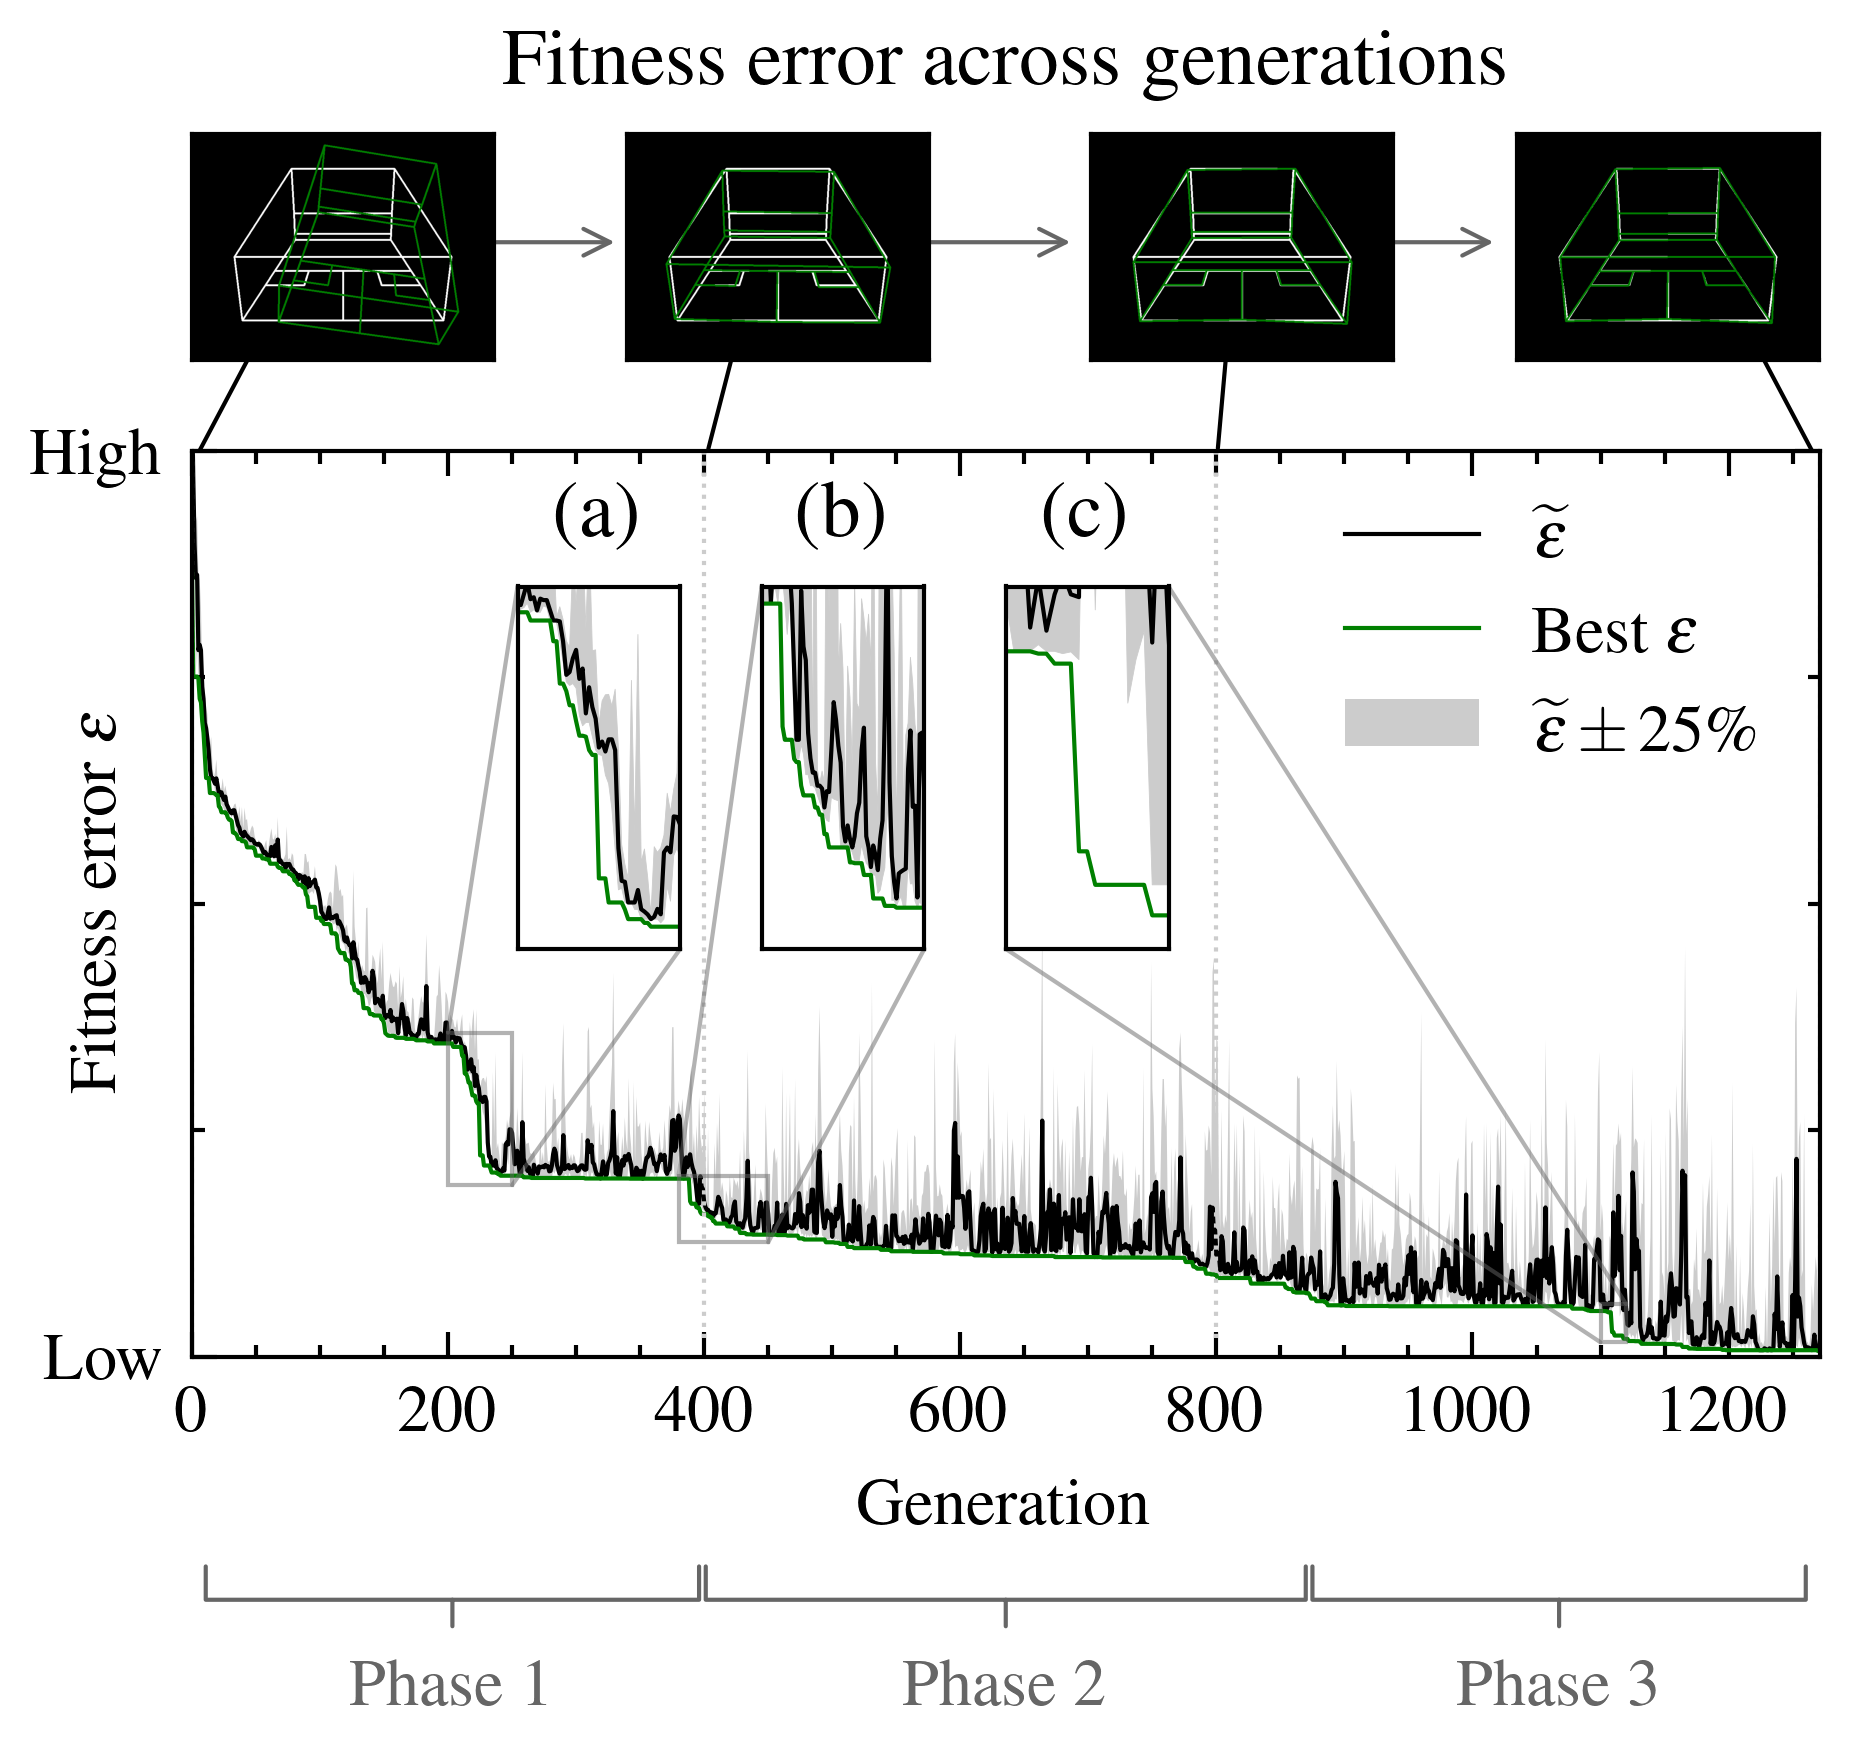

In [18]:

def plot_history(best_values, lo_values, mid_values, hi_values, best_individuals):
    generations = np.arange(len(best_values))
    PAPER_SIZE = (3.50, 2.0)
    DEBUG_SIZE = (16, 9)
    FIGURE_SIZE = PAPER_SIZE
    fig, ax = plt.subplots(figsize=FIGURE_SIZE)

    ax.fill_between(x=generations, y1=lo_values, y2=hi_values, color=(.8, .8, .8), lw=0, label="\(\widetilde{\epsilon} \pm 25\%\)")
    ax.plot(generations, mid_values, 'k', lw=0.5, ls="-", label="\(\widetilde{\epsilon}\)")
    ax.plot(generations, best_values, 'g', lw=0.5, label="Best \(\epsilon\)")

    maximum_value = max(hi_values)

    def add_zoom_inset(axes, pos, values, label=""):
        inset_axes = axes.inset_axes(pos, xticklabels="", xticks=[], yticklabels="", yticks=[])
        inset_axes.fill_between(x=generations, y1=lo_values, y2=hi_values, lw=0.1, color=(.8, .8, .8),)
        inset_axes.plot(generations, mid_values, 'k', ls="-", lw=0.5)
        inset_axes.plot(generations, best_values, 'g', lw=0.5)
        inset_axes.set_title(label)

        x1, x2, y1, y2 = values

        inset_axes.set_xlim(x1, x2)
        inset_axes.set_ylim(y1, y2)

        for axis in ['top','bottom','left','right']:
            inset_axes.spines[axis].set_linewidth(0.5)

        (rectangle_patch, connector_lines) = ax.indicate_inset_zoom(inset_axes, edgecolor=(0.4, 0.4, 0.4), lw=0.5)
        for line in connector_lines:
            line.set_linewidth(0.5)
        
        return inset_axes


    first_big_step = add_zoom_inset(ax, (0.2, 0.45, 0.1, 0.4), (200, 250, 1800, 3400), "(a)")
    second_big_step = add_zoom_inset(ax, (0.35, 0.45, 0.1, 0.4), (380, 450, 1200, 1900), "(b)")
    late_adaption = add_zoom_inset(ax, (0.50, 0.45, 0.1, 0.4), (1100, 1120, 150, 550), "(c)")

    def add_camera_inset(axes, normalized_x, best_individuals, selected_generation):
        individual = best_individuals[selected_generation]
        def construct_camera(key, color, camera_dna):
            value = {
                "A": np.array([camera_dna[0], 0, camera_dna[2],
                                0, camera_dna[1], camera_dna[3],
                                0, 0, 1]).reshape((3, 3)),
                "t": camera_dna[4:7],
                "r": camera_dna[7:10],
                "d": camera_dna[10:],
                "color": color
                }
            return {key: value}

        cameras = {}

        cameras.update(construct_camera("real_camera", (255, 255, 255), real_dna))
        cameras.update(construct_camera("inset_loc", (0, 128, 0), individual))
        camera_projection_rendering = np.zeros((image_height, image_width, 3), dtype=np.uint8)

        for k, camera in cameras.items():
            render_geometry_with_camera(camera_projection_rendering, real_geometry, camera["A"], camera["t"], camera["r"], camera["d"], camera["color"], line_thickness=4)

        axes.annotate("",
                xytext=(normalized_x+0.125, 1.3), textcoords='axes fraction',
                xy=(selected_generation, maximum_value-150), xycoords='data',
                arrowprops=dict(arrowstyle="-",
                                lw=0.5, color=(0, 0, 0)))

        axes.axvline(x=selected_generation, ymin=0.02, lw=0.5, ls=":", color=(.8, .8, .8))
        inset_axes_rendering = axes.inset_axes((normalized_x, 1.1, 0.25, 0.25), xticklabels="", xticks=[], yticklabels="", yticks=[])
        inset_axes_rendering.imshow(camera_projection_rendering)


    add_camera_inset(ax, -0.032, best_individuals, 0)
    add_camera_inset(ax, +0.235, best_individuals, 400)
    add_camera_inset(ax, +0.520, best_individuals, 800)
    add_camera_inset(ax, +0.782, best_individuals, len(best_values)-300)

    def add_arrow(axes, x_start, x_end):
        axes.annotate("",
                xytext=(x_start, 1.23), textcoords='axes fraction',
                xy=(x_end, 1.23), xycoords='axes fraction',
                arrowprops=dict(arrowstyle="->",
                                lw=0.5, color=(.4, .4, .4)))
    
    def add_phase(axes, text, x_pos, width, y_shift=-0.2):
        axes.annotate(text, xy=(x_pos, y_shift), xytext=(x_pos, y_shift-0.15), xycoords="axes fraction",
            ha="center", va="bottom",
            color=(.4, .4, .4),
            arrowprops=dict(arrowstyle=f"-[, widthB={width}, lengthB=0.5", lw=0.5, color=(.4, .4, .4)))


    add_arrow(ax, 0.15, 0.27)
    add_arrow(ax, 0.44, 0.55)
    add_arrow(ax, 0.62, 0.81)

    add_phase(ax, "Phase 1", 0.16, 3.7, -0.25)
    add_phase(ax, "Phase 2", 0.50, 4.5, -0.25)
    add_phase(ax, "Phase 3", 0.84, 3.7, -0.25)

    ax.set_xlim(0, len(best_values)-300)
    ax.set_ylim(0, maximum_value)
    ax.legend()
    ax.set_yticks([0, maximum_value])
    ax.set_yticklabels(["Low", "High"])
    ax.set_xlabel("Generation")#, labelpad=24)
    ax.set_title("Fitness error across generations") 

    ax.set_ylabel("Fitness error \(\epsilon\)", labelpad=-12)

    return fig

fig = plot_history(best_values, lo_values, mid_values, hi_values, best_individuals)
save_figure(fig, f"{OUTPUT_FOLDER}/errorplot.eps")

# Distances

In [19]:
result_dna = populations[:, 0, :] # extract best (0th) individuum every 100th generation
result_distances = np.abs(target_dna - result_dna)

start_distance = np.abs(target_dna - start_dna)

with np.printoptions(precision=2, suppress=True, threshold=1000, linewidth=1000):
    print("S", start_dna)
    print("T", target_dna)
    print("R", result_dna[-1])
    print("")
    print("D", result_distances[-1])




S [800.   800.   432.   332.     0.3    3.35  11.4    0.64   0.     0.17   0.     0.     0.     0.     0.  ]
T [700.   700.   400.   300.     0.     2.35   8.4    0.29   0.     0.     0.     0.     0.     0.     0.  ]
R [755.11 748.19 378.94 306.27   0.23   2.27   9.13   0.3    0.03  -0.01  -0.35   1.63   0.01  -0.01   4.92]

D [55.11 48.19 21.06  6.27  0.23  0.08  0.73  0.01  0.03  0.01  0.35  1.63  0.01  0.01  4.92]
